# Piecewise polynomial segmentation

Inspired by the example in
> Fearnhead, Paul, and Zhen Liu. "Efficient Bayesian analysis of multiple changepoint models with dependence across segments." Statistics and Computing 21 (2011): 217-229.


In [1]:
import jax
import numpy as np
import pandas as pd
import seaborn as sns
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm import tqdm
from functools import partial

In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["font.size"] = 15
plt.rcParams["axes.spines.right"]= False
plt.rcParams["axes.spines.top"] = False
plt.rc("text", usetex=True)

sns.set_palette("colorblind")

## The choice of (M.1)

In [3]:
import chex
import einops
import distrax
from jax.flatten_util import ravel_pytree
from rebayes_mini.states import GaussState
from rebayes_mini.methods.adaptive import GaussPositionRLPR, WoLFPositionRLPR
from rebayes_mini.methods.gauss_filter import ExtendedKalmanFilter, BeliefExtendedKalmanFilter

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import jax
import distrax
import numpy as np
import pandas as pd
import seaborn as sns
import jax.numpy as jnp
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from tqdm import tqdm
from functools import partial
from rebayes_mini.callbacks import get_predicted_mean
from rebayes_mini.methods.gauss_filter import GaussianFilter
from rebayes_mini.methods.adaptive import LinearModelFMBOCD
from rebayes_mini.methods.adaptive import RobustLinearModelFMBOCD

In [6]:
sns.set_palette("colorblind")

In [7]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["font.size"] = 15
plt.rcParams["axes.spines.right"]= False
plt.rcParams["axes.spines.top"] = False
plt.rc("text", usetex=True)

sns.set_palette("colorblind")

In [8]:
@partial(jax.vmap, in_axes=(None, 0))
def get_segment_init(segment, n):
    return jnp.where(segment == n, size=len(segment))[0][0] 

In [473]:
def step(params, key, p_change):
    key_x, key_y, key_change, key_params = jax.random.split(key, 4)

    change = jax.random.uniform(key_change) < p_change

    key_theta0, key_theta1, key_theta2 = jax.random.split(key_params, 3)
    params_change = jax.random.uniform(key_params, (3,), minval=-3, maxval=3)
    
    params = params * (1 - change) + params_change * change

    x = jax.random.uniform(key_x, minval=-2, maxval=2)
    phi = jnp.c_[1, x, x ** 2]
    
    yclean = phi @ params
    y = yclean + jax.random.t(key_y, df=2.1)

    out = {
        "params": params,
        "y": y,
        "x": jnp.atleast_1d(x),
        "yclean": yclean,
        "change": change,
    }

    return params, out


@partial(jax.jit, static_argnames=("n_samples",))
def sample_run(key, n_samples, p_change):
    theta_init = jnp.array([1.0, 1.0, 1.0])
    keys = jax.random.split(key, n_samples)
    _step = partial(step, p_change=p_change)
    _, hist = jax.lax.scan(_step, theta_init, keys)
    return hist

In [474]:
key = jax.random.PRNGKey(27)
n_samples = 300
p_change = 0.01
hist = sample_run(key, n_samples, p_change)

In [475]:
segment = np.array(hist["change"].cumsum())
n_segments = len(np.unique(segment))
n_segments

6

In [476]:
n_segments = len(np.unique(segment))
segments_init = get_segment_init(segment, jnp.arange(n_segments))
segments_init = np.array(segments_init)

In [477]:
cmap = {
    # s: plt.cm.tab10(s)
    s: sns.color_palette()[s]
    for s in range(n_segments)
}

colors = [cmap[s] for s in segment]

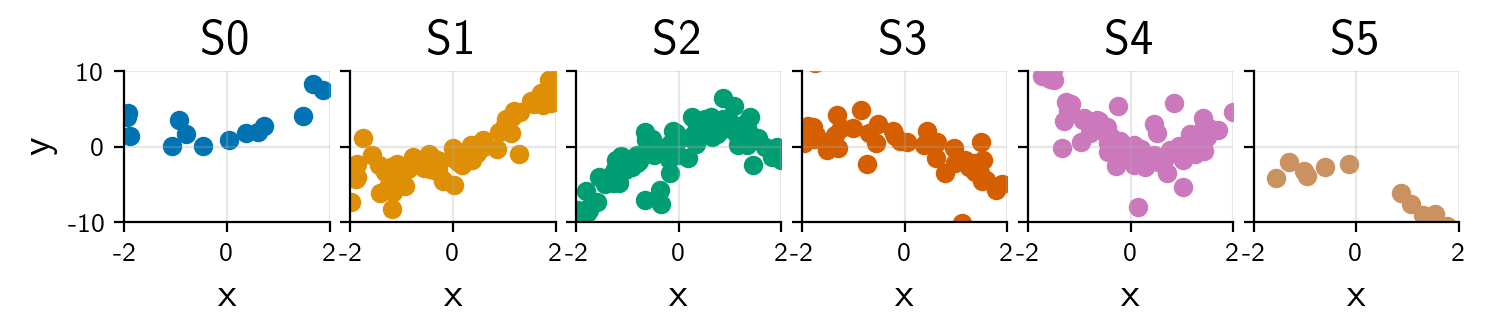

In [478]:
fig, axs = plt.subplots(1, n_segments, sharey=True, figsize=(6.4 * 1.2, 4.8 * 0.4))
axs = axs.ravel()
    
for n in np.arange(n_segments):
    axs[n].set_title(f"S{n}")
    color = cmap[n]
    ixs = jnp.where(segment == n)[0]
    xsub = hist["x"][ixs]
    ysub = hist["y"][ixs]
    axs[n].scatter(xsub, ysub, color=color)
    axs[n].grid(alpha=0.3)
    axs[n].set_xlabel("x")
    axs[n].set_xlim(-2, 2)
    axs[n].set_ylim(top=10, bottom=-10)
    axs[n].set_yticks([-10, 0, 10], labels=["-10", "0", "10"], fontsize=10)
    axs[n].set_xticks([-2, 0, 2], labels=["-2", "0", "2"], fontsize=10)
    

axs[0].set_ylabel("y")
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)
plt.savefig("../figures/segments-tdist-lr.png", dpi=300, bbox_inches="tight")

In [479]:
X = hist["x"]
y = hist["y"]

## Building the measurment model

In [480]:
def build_features(x, _):
    delta = x# - last_x
    phi = jnp.array([delta ** 0, delta ** 1, delta ** 2])
    return phi

def apply_fn(mean, x, bel):
    phi = build_features(x, None)
    yhat =  phi.T @ mean
    return jnp.atleast_1d(yhat)

In [481]:
def callback_static(bel, bel_prior, y, X):
    Ht = build_features(X, None)
    yhat = Ht.T @ bel_prior.mean

    out = {
        "yhat": yhat,
        "err": y - yhat
    }
    return out

In [482]:
def callback(bel, bel_prior, y, X, ixs):
    log_posterior = bel_prior.log_joint - jax.nn.logsumexp(bel_prior.log_joint, keepdims=True)
    posterior = jnp.exp(log_posterior)

    pred_values = jax.vmap(apply_fn, in_axes=(0, None, 0))(bel_prior.mean, X, bel_prior)
    pred = posterior @ pred_values

    Ht = build_features(X, bel_prior.last_x)
    var_pred = jnp.einsum("nk,knm,mk,k->", Ht, bel_prior.cov, Ht, posterior)
    var_pred = var_pred + std_measurements ** 2
    
    out = {
        "log_joint": bel.log_joint,
        "runlength": bel.runlength,
        "ixs": ixs,
        "err": y - pred,
        "yhat": pred,
        "yhat_var": var_pred,
    }
    return out

## RL with moment matching

In [483]:
std_measurements = 1.0

In [484]:
filter = BeliefExtendedKalmanFilter(
    lambda x: x, apply_fn, jnp.eye(3) * 0.0, observation_covariance=1.0
)
p_change = 0.01
afilter = GaussPositionRLPR(p_change, K=n_samples, filter=filter, moment_match=True)

In [485]:
mean = jnp.zeros(3)
cov = jnp.eye(3) * 1.0

bel_init = afilter.init_bel(mean, cov, 0.0, X[-1])
bel_final, hist_mm = afilter.scan(y, X, bel_init, callback)

In [486]:
log_posterior = hist_mm["log_joint"] - jax.nn.logsumexp(hist_mm["log_joint"], axis=-1, keepdims=True)
posterior = jnp.exp(log_posterior)

In [487]:
jnp.sqrt(jnp.power(hist_mm["err"], 2).mean())

Array(4.5481906, dtype=float32)

In [488]:
ymin_mm = hist_mm["yhat"].squeeze() - 2 * jnp.sqrt(hist_mm["yhat_var"].squeeze())
ymax_mm = hist_mm["yhat"].squeeze() + 2 * jnp.sqrt(hist_mm["yhat_var"].squeeze())

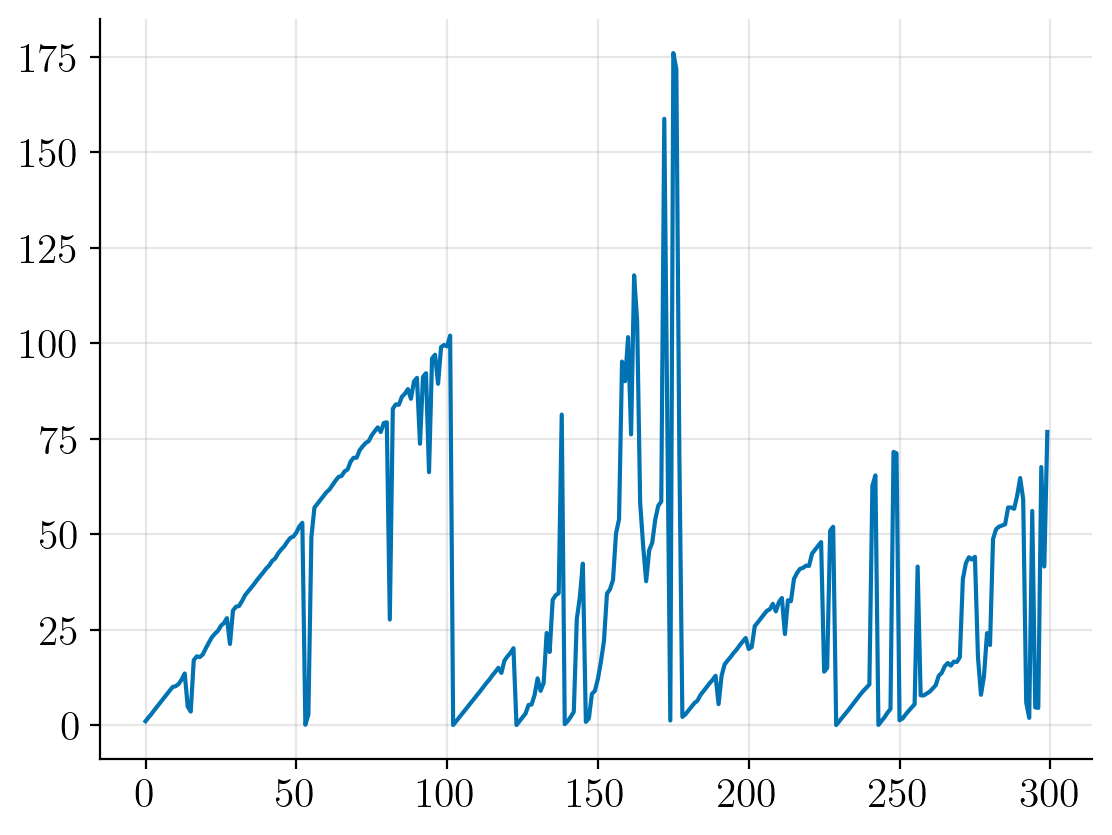

In [489]:
expected_runlength_rlmmpr = jnp.einsum("tk,tk->t", hist_mm["runlength"], posterior)
plt.plot(expected_runlength_rlmmpr)
plt.grid(alpha=0.3)

In [490]:
log_posterior_grid = np.array(log_posterior)
log_posterior_grid[np.abs(log_posterior_grid) == np.inf] = np.nan

In [491]:
runlenght_hist = hist_mm["runlength"] + np.triu(np.ones((n_samples, n_samples)), k=2) * (n_samples + 1)
ix_sort = np.argsort(runlenght_hist, axis=1)

log_posterior_grid_sort = np.take_along_axis(log_posterior_grid, ix_sort, axis=1)

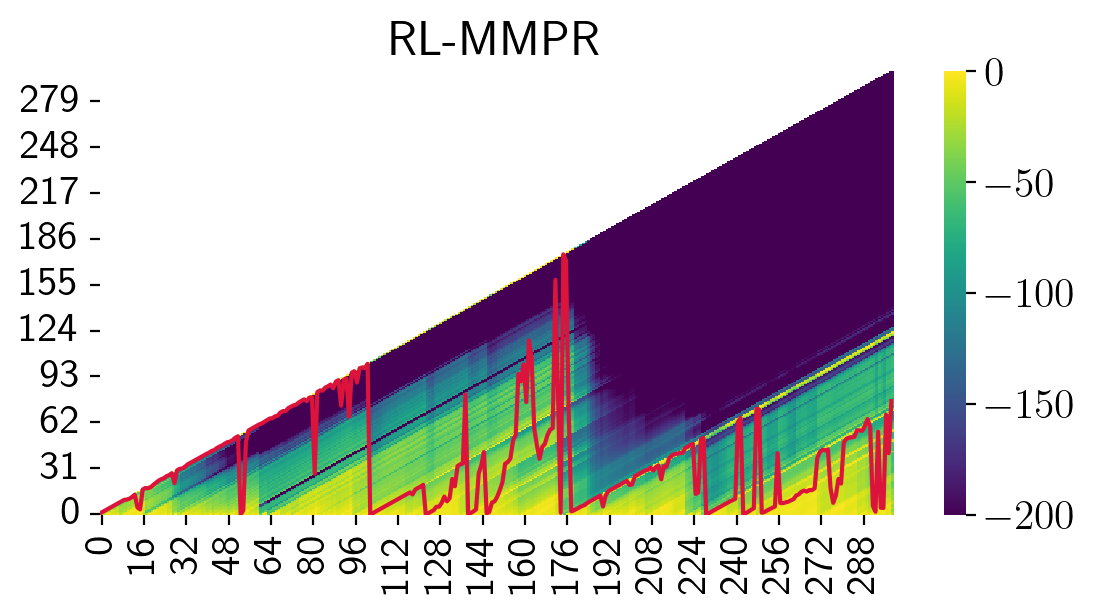

In [492]:
fig, ax = plt.subplots(figsize=(6.4, 4.8 * 0.6))
plt.title(r"$\texttt{LG+RL[inf]-MMPR}$")

T = 300
sns.heatmap(log_posterior_grid_sort[:T, :T].T, cmap="viridis", vmin=-200)
# plt.plot(np.nanargmax(log_posterior_grid_sort, axis=1), c="crimson")
plt.plot(expected_runlength_rlmmpr, c="crimson")
plt.title("RL-MMPR")
plt.gca().invert_yaxis()

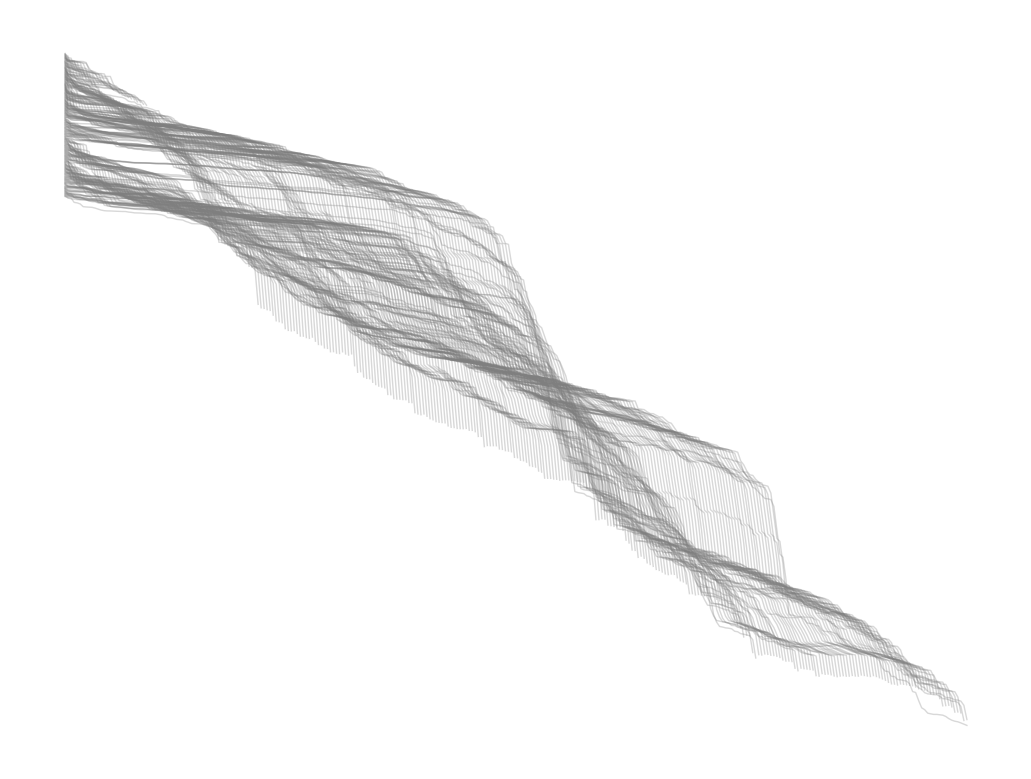

In [493]:
for i in range(0, 300):
    plt.plot(-i + log_posterior_grid[i], c="tab:gray", alpha=0.3, linewidth=0.5)
plt.axis("off");

## RL without moment-matching

In [494]:
filter = BeliefExtendedKalmanFilter(
    lambda x: x, apply_fn, jnp.eye(3) * 0.0, observation_covariance=1.0
)
p_change = 0.01
afilter = GaussPositionRLPR(p_change, K=n_samples, filter=filter, moment_match=False)

In [495]:
mean = jnp.zeros(3)
cov = jnp.eye(3) * 1.0

bel_init = afilter.init_bel(mean, cov, 0.0, X[0])
bel_final, hist_rlpr = afilter.scan(y, X, bel_init, callback)

In [496]:
log_posterior = hist_rlpr["log_joint"] - jax.nn.logsumexp(hist_rlpr["log_joint"], axis=-1, keepdims=True)
posterior = jnp.exp(log_posterior)

In [497]:
jnp.sqrt(jnp.power(hist_rlpr["err"], 2).mean())

Array(4.111514, dtype=float32)

In [498]:
ymin_rlpr = hist_rlpr["yhat"].squeeze() - 2 * jnp.sqrt(hist_rlpr["yhat_var"].squeeze())
ymax_rlpr = hist_rlpr["yhat"].squeeze() + 2 * jnp.sqrt(hist_rlpr["yhat_var"].squeeze())

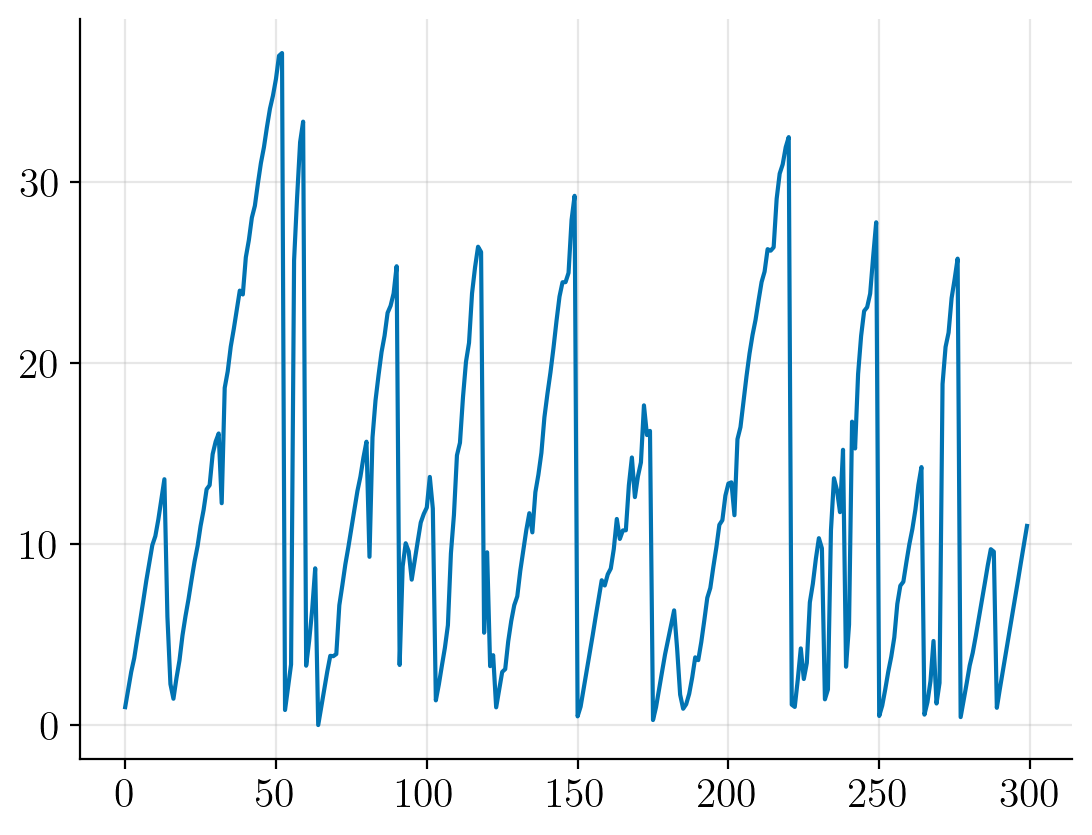

In [499]:
expected_runlength_rlpr = jnp.einsum("tk,tk->t", hist_rlpr["runlength"], posterior)
plt.plot(expected_runlength_rlpr)
plt.grid(alpha=0.3)

In [500]:
log_posterior = (
    hist_rlpr["log_joint"] - jax.nn.logsumexp(hist_rlpr["log_joint"], axis=-1, keepdims=True)
)

In [501]:
log_posterior_grid = np.array(log_posterior)
log_posterior_grid[np.abs(log_posterior_grid) == np.inf] = np.nan

In [502]:
runlenght_hist = hist_rlpr["runlength"] + np.triu(np.ones((n_samples, n_samples)), k=2) * (n_samples + 1)
ix_sort = np.argsort(runlenght_hist, axis=1)

log_posterior_grid_sort = np.take_along_axis(log_posterior_grid, ix_sort, axis=1)

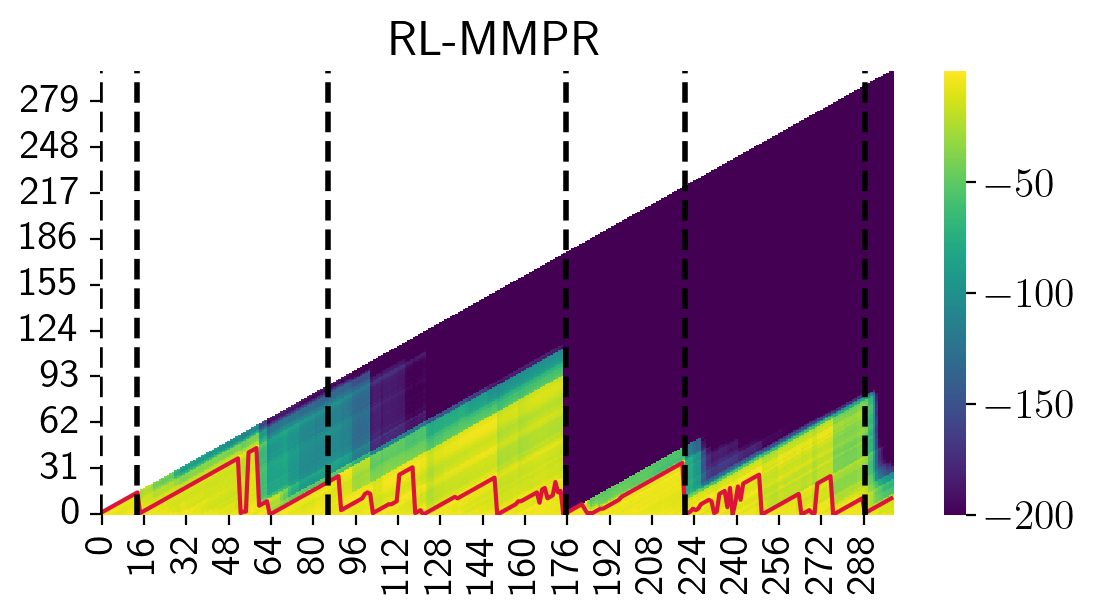

In [503]:
fig, ax = plt.subplots(figsize=(6.4, 4.8 * 0.6))
plt.title(r"$\texttt{LG+RL[inf]-PR}$")

T = 300
sns.heatmap(log_posterior_grid_sort[:T, :T].T, cmap="viridis", vmin=-200)
plt.plot(np.nanargmax(log_posterior_grid_sort, axis=1), c="crimson")
plt.title("RL-MMPR")
plt.gca().invert_yaxis()

for s in segments_init:
    plt.axvline(x=s, c="black", linestyle="--", alpha=1.0, linewidth=2)

## WOLF+RL-PR without moment-matching

In [504]:
from rebayes_mini.methods.robust_filter import BeliefExtendedKalmanFilterIMQ

In [505]:
c = 6.0
filter = BeliefExtendedKalmanFilterIMQ(
    lambda x: x, apply_fn, jnp.eye(3) * 0.0, observation_covariance=1.0,
    soft_threshold=c
)
p_change = 0.01
afilter = WoLFPositionRLPR(p_change, K=n_samples, filter=filter, moment_match=False, c=c)

In [506]:
mean = jnp.zeros(3)
cov = jnp.eye(3) * 1.0

bel_init = afilter.init_bel(mean, cov, 0.0, X[0])
bel_final, hist_wolf_rlpr = afilter.scan(y, X, bel_init, callback)

In [507]:
log_posterior = hist_wolf_rlpr["log_joint"] - jax.nn.logsumexp(hist_wolf_rlpr["log_joint"], axis=-1, keepdims=True)
posterior = jnp.exp(log_posterior)

In [508]:
jnp.sqrt(jnp.power(hist_wolf_rlpr["err"], 2).mean())

Array(3.7221847, dtype=float32)

In [509]:
ymin_rlpr = hist_wolf_rlpr["yhat"].squeeze() - 2 * jnp.sqrt(hist_wolf_rlpr["yhat_var"].squeeze())
ymax_rlpr = hist_wolf_rlpr["yhat"].squeeze() + 2 * jnp.sqrt(hist_wolf_rlpr["yhat_var"].squeeze())

In [510]:
log_posterior = (
    hist_wolf_rlpr["log_joint"] - jax.nn.logsumexp(hist_wolf_rlpr["log_joint"], axis=-1, keepdims=True)
)

In [511]:
log_posterior_grid = np.array(log_posterior)
log_posterior_grid[np.abs(log_posterior_grid) == np.inf] = np.nan

In [512]:
runlenght_hist = hist_wolf_rlpr["runlength"] + np.triu(np.ones((n_samples, n_samples)), k=2) * (n_samples + 1)
ix_sort = np.argsort(runlenght_hist, axis=1)

log_posterior_grid_sort = np.take_along_axis(log_posterior_grid, ix_sort, axis=1)

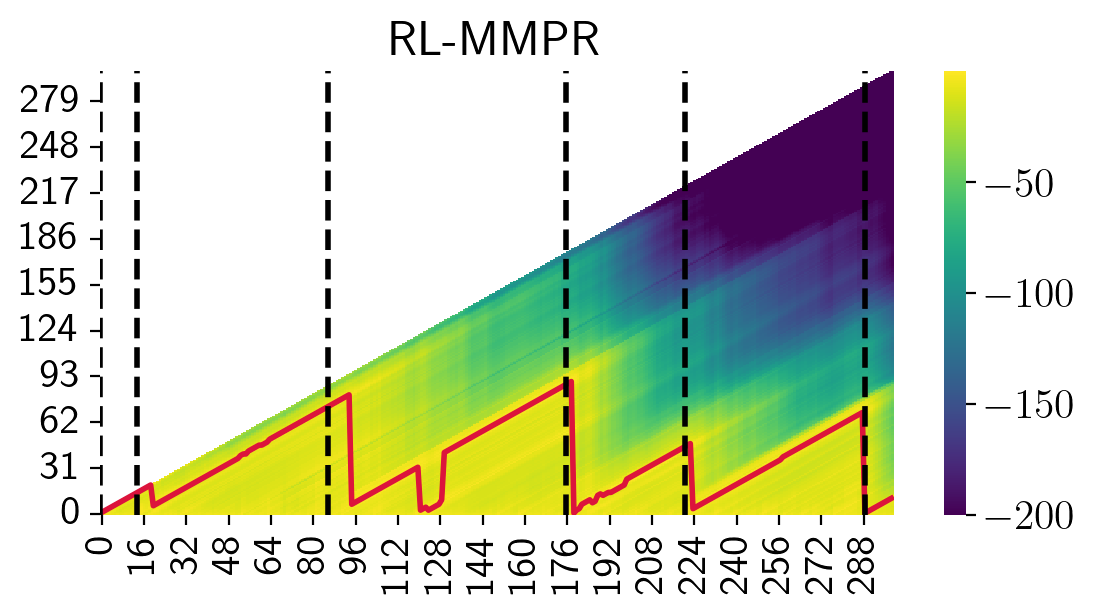

In [513]:
fig, ax = plt.subplots(figsize=(6.4, 4.8 * 0.6))
plt.title(r"$\texttt{LG+RL[inf]-PR}$")

T = 300
sns.heatmap(log_posterior_grid_sort[:T, :T].T, cmap="viridis", vmin=-200)
plt.plot(np.nanargmax(log_posterior_grid_sort, axis=1), c="crimson")

plt.plot(hist_wolf_rlpr["runlength"][:, 0], c="crimson", linewidth=2)

for s in segments_init:
    plt.axvline(x=s, c="black", linestyle="--", alpha=1.0, linewidth=2)

plt.title("RL-MMPR")
plt.gca().invert_yaxis()

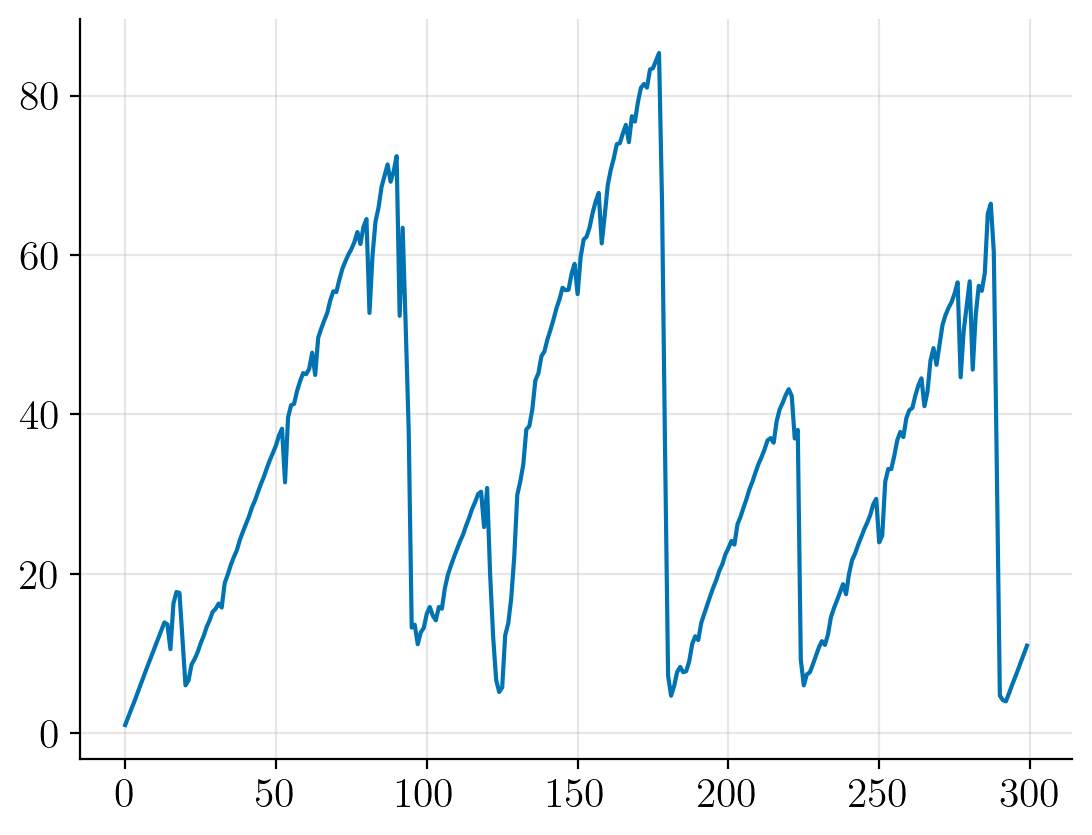

In [514]:
expected_runlength_rlpr = jnp.einsum("tk,tk->t", hist_wolf_rlpr["runlength"], posterior)
plt.plot(expected_runlength_rlpr)
plt.grid(alpha=0.3)

# Simulations

In [515]:
n_sims = 50
key = jax.random.PRNGKey(314)
keys = jax.random.split(key, n_sims)

In [518]:
vhist = jax.vmap(sample_run, in_axes=(0, None, None))(keys, n_samples, p_change)

In [519]:
@jax.vmap
def rlpr_run(y, X):
    filter = BeliefExtendedKalmanFilter(
        lambda x: x, apply_fn, jnp.eye(3) * 0.0, observation_covariance=1.0
    )
    p_change = 0.01
    afilter = GaussPositionRLPR(p_change, K=n_samples, filter=filter, moment_match=False)
    
    mean = jnp.zeros(3)
    cov = jnp.eye(3) * 1.0
    
    bel_init = afilter.init_bel(mean, cov, 0.0, X[0])
    bel_final, hist_rlpr = afilter.scan(y, X, bel_init, callback)
    return hist_rlpr["yhat"]

@partial(jax.vmap, in_axes=(0, 0, None))
def wolf_rlpr_run(y, X, c):
    filter = BeliefExtendedKalmanFilterIMQ(
        lambda x: x, apply_fn, jnp.eye(3) * 0.0, observation_covariance=1.0,
        soft_threshold=c
    )
    p_change = 0.01
    afilter = WoLFPositionRLPR(p_change, K=n_samples, filter=filter, moment_match=False, c=c)
    
    mean = jnp.zeros(3)
    cov = jnp.eye(3) * 1.0
    
    bel_init = afilter.init_bel(mean, cov, 0.0, X[0])
    bel_final, hist_wolf_rlpr = afilter.scan(y, X, bel_init, callback)
    return hist_wolf_rlpr["yhat"]

@jax.vmap
def static_run(y, X):
    filter = BeliefExtendedKalmanFilter(
        lambda x: x, apply_fn, jnp.eye(3) * 0.0, observation_covariance=1.0
    )

    mean = jnp.zeros(3)
    cov = jnp.eye(3) * 1.0

    bel_init = filter.init_bel(mean, cov)
    bel_final, hist = filter.scan(bel_init, y, X, callback_static)
    return hist["yhat"]

In [520]:
vy_clean = vhist["yclean"]
vX = vhist["x"]
vchanges = vhist["change"]

In [543]:
err_rlpr_hist = rlpr_run(vy, vX)

In [544]:
err_static = static_run(vy, vX)

In [587]:
c = 4.0
err_wolf_rlpr_hist = wolf_rlpr_run(vy, vX, c)

In [592]:
df_all = {
    "WoLF+RL-PR": err_wolf_rlpr_hist,
    "LG+RL-PR": err_rlpr_hist,
    "LG+C+Static": err_static,
}

df_all = jax.tree.map(lambda x: (x - vy_clean).squeeze(), df_all)

# df_res = jax.tree.map(lambda x: np.sqrt(np.median(np.power(x, 2), axis=1)), df_all)
df_res = jax.tree.map(lambda x: np.sqrt(np.mean(np.power(x, 2), axis=1)), df_all)
df_res = pd.DataFrame(df_res)
df_res.columns = [r"$\texttt{" + c + "}$" for c in df_res.columns]

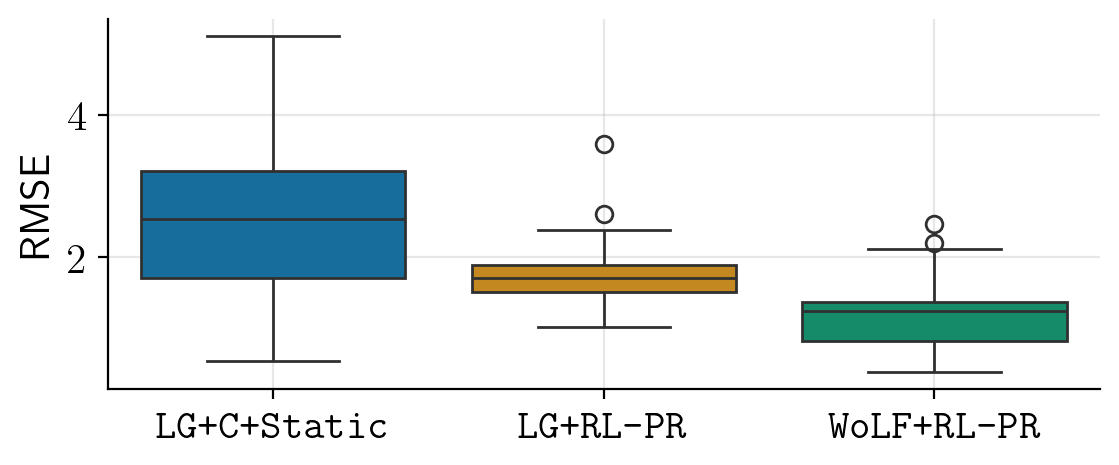

In [623]:
fig, ax = plt.subplots(figsize=(6.4, 4.8 * 0.5))

sns.boxplot(
    x="variable",
    y="value",
    hue="variable",
    data=df_res.melt(),
)
plt.ylabel("RMSE")
plt.grid(alpha=0.3)
plt.xlabel("")
plt.savefig("../figures/rl-pr-outliers-res.png", dpi=300, bbox_inches="tight")

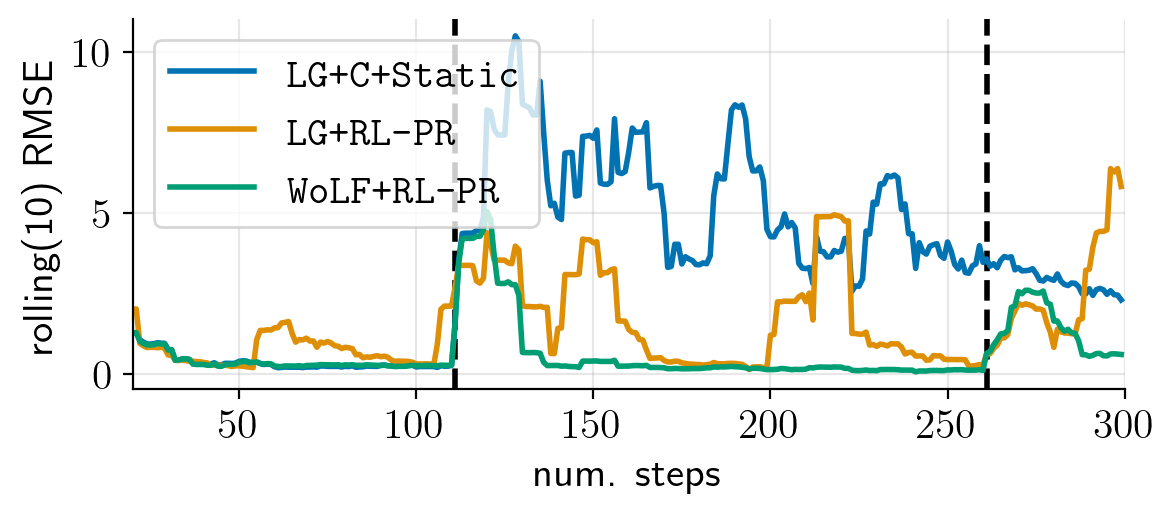

In [622]:
s = 36

segment = np.array(vchanges[s].cumsum())
n_segments = len(np.unique(segment))
n_segments

n_segments = len(np.unique(segment))
segments_init = get_segment_init(segment, jnp.arange(n_segments))
segments_init = np.array(segments_init)

fig, ax = plt.subplots(figsize=(6.4, 4.8 * 0.5))


sim = jax.tree.map(lambda x: np.array(x[s]), df_all)
sim = pd.DataFrame(sim)
sim.columns = [r"$\texttt{" + c + "}$" for c in sim.columns]

for s in segments_init[1:]:
    plt.axvline(x=s, c="black", linestyle="--", alpha=1.0, linewidth=2)

plt.ylabel("rolling(10) RMSE")
plt.xlabel("num. steps")
plt.xlim(20, 300)
np.sqrt(np.power(sim, 2).rolling(10).mean()).plot(linewidth=2, ax=ax)
# sim.abs().rolling(10).median().plot()
# plt.yscale("log")
plt.grid(alpha=0.3)
plt.savefig("../figures/rl-pr-outliers-sample-run.png", dpi=300, bbox_inches="tight")